# ASR Analysis: Score vs Number of Samples (Direct Request Only)

This notebook analyzes the relationship between attack success rate scores and the number of samples used, focusing on direct_request data with 3 samples per combination.

We use the theoretical formula for expected maximum of s samples from n=3 observations:

$$\operatorname{E}[M] = \frac{1}{\binom{n}{s}} \sum_{k=s}^{n} x_{(k)} \binom{k-1}{s-1}$$

where $x_{(1)} \le x_{(2)} \le x_{(3)}$ are the ordered scores.

This notebook loads data from the main results CSV file and processes it to generate theoretical analysis plots.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.optimize import curve_fit
import ast
import os
import sys
from typing import Dict, List

# Add parent directory to path for imports
sys.path.append('..')

# Set style to match reference notebook
plt.style.use('default')

In [20]:
# Helper function to safely parse scores
def parse_scores(score_str):
    """Parse score string to list of floats"""
    try:
        if pd.isna(score_str) or score_str == '[]':
            return []
        # Handle string representation of list
        if isinstance(score_str, str):
            return ast.literal_eval(score_str)
        return score_str
    except:
        return []

# Function to calculate expected maximum for s samples from n observations
def expected_max_formula(scores, s, n=None):
    """Calculate expected maximum using the theoretical formula"""
    if n is None:
        n = len(scores)
    
    if len(scores) != n or s > n or s < 1:
        return np.nan
    
    # Sort scores to get order statistics
    x_ordered = sorted(scores)
    
    # Calculate expected maximum
    expected_val = 0.0
    for k in range(s, n + 1):
        # x_(k) is the k-th order statistic (1-indexed)
        x_k = x_ordered[k - 1]  # Convert to 0-indexed
        
        # Binomial coefficient C(k-1, s-1)
        binom_coeff = comb(k - 1, s - 1, exact=True)
        
        expected_val += x_k * binom_coeff
    
    # Normalize by C(n, s)
    expected_val /= comb(n, s, exact=True)
    
    return expected_val

In [21]:
# ============================================================================
# DATA LOADING AND PROCESSING
# ============================================================================

# Load data from main results CSV
csv_path = "../csv_results/results_strongreject.csv"

print("Loading and processing CSV data...")
print(f"Data source: {csv_path}")

if not os.path.exists(csv_path):
    print(f"✗ CSV file not found: {csv_path}")
    print("Please check that the results file exists.")
    metadata = pd.DataFrame()
else:
    # Load and filter data to direct_request from available batches
    df = pd.read_csv(csv_path)
    print(f"Total rows in dataset: {len(df)}")
    
    # Check available data
    print(f"Available jailbreak tactics: {sorted(df['jailbreak_tactic'].unique())}")
    print(f"Available turn types: {df['turn_type'].value_counts()}")
    
    # Filter to direct_request only
    direct_request_data = df[df['jailbreak_tactic'] == 'direct_request'].copy()
    print(f"Rows with direct_request: {len(direct_request_data)}")
    
    # Parse scores and get max score for each row
    direct_request_data['parsed_scores'] = direct_request_data['scores'].apply(parse_scores)
    direct_request_data['max_score'] = direct_request_data['parsed_scores'].apply(lambda x: max(x) if x else 0.0)
    
    # Create combination identifier (test_case + model + turn_type + temp)
    direct_request_data['combination'] = (direct_request_data['test_case'] + '_' + 
                                           direct_request_data['target_model'] + '_' + 
                                           direct_request_data['turn_type'] + '_' + 
                                           direct_request_data['target_temp'].astype(str))
    
    # Count samples per combination
    combination_counts = direct_request_data['combination'].value_counts()
    print("Sample count distribution:")
    print(combination_counts.value_counts().sort_index())
    
    # Find combinations with 2+ samples (we'll work with what we have)
    combinations_with_multiple = combination_counts[combination_counts >= 2].index
    batch_multiple_samples = direct_request_data[direct_request_data['combination'].isin(combinations_with_multiple)].copy()
    
    print(f"\nCombinations with 2+ samples: {len(combinations_with_multiple)}")
    print(f"Total rows with 2+ sample combinations: {len(batch_multiple_samples)}")
    
    # Calculate expected maximums for available samples for each combination
    combination_data = []
    
    for combo in combinations_with_multiple:
        combo_rows = batch_multiple_samples[batch_multiple_samples['combination'] == combo]
        scores = combo_rows['max_score'].tolist()
        n_samples = len(scores)
        
        if n_samples >= 2:
            # Calculate expected maximums for s=1 up to n_samples
            exp_maxes = {}
            for s in range(1, n_samples + 1):
                exp_maxes[f'max_score_by_{s}_sample'] = expected_max_formula(scores, s, n_samples)
            
            # Extract metadata from combination
            first_row = combo_rows.iloc[0]
            
            row_data = {
                'combination': combo,
                'test_case': first_row['test_case'],
                'target_model': first_row['target_model'],
                'turn_type': first_row['turn_type'],
                'target_temp': first_row['target_temp'],
                'scores': scores,
                'n_samples': n_samples
            }
            row_data.update(exp_maxes)
            
            combination_data.append(row_data)
    
    metadata = pd.DataFrame(combination_data)
    
    if len(metadata) > 0:
        print(f"\n✓ Successfully processed {len(metadata)} combinations")
        print(f"Models: {sorted(metadata['target_model'].unique())}")
        print(f"Turn types: {metadata['turn_type'].value_counts()}")
        print(f"Sample sizes available: {sorted(metadata['n_samples'].unique())}")
    else:
        print("✗ No valid combinations found with 2+ samples.")

print("\nReady for analysis and plotting!")

Loading and processing CSV data...
Data source: ../csv_results/results_strongreject.csv
Total rows in dataset: 1638
Available jailbreak tactics: ['acronym', 'actor_attack', 'command', 'crescendomation', 'crowding', 'direct_request', 'emotional_appeal', 'opposite_day']
Available turn types: turn_type
multi     1008
single     630
Name: count, dtype: int64
Rows with direct_request: 252
Sample count distribution:
count
1    84
2    84
Name: count, dtype: int64

Combinations with 2+ samples: 84
Total rows with 2+ sample combinations: 168

✓ Successfully processed 84 combinations
Models: ['gpt-4o-mini-2024-07-18', 'meta-llama/llama-3.1-405b-instruct', 'meta-llama/llama-3.1-70b-instruct', 'meta-llama/llama-3.1-8b-instruct', 'meta-llama/llama-3.2-1b-instruct', 'meta-llama/llama-3.2-3b-instruct', 'meta-llama/llama-3.3-70b-instruct']
Turn types: turn_type
single    42
multi     42
Name: count, dtype: int64
Sample sizes available: [np.int64(2)]

Ready for analysis and plotting!


In [22]:
# Define fitting function (same as reference notebook)
def formula(s, A, B, c):
    return A - B * np.exp(-c * s)

def fit_formula(s_data, y_data):
    """Fit the model to the data using curve fitting."""
    # Initial guess for parameters A, B, c
    initial_guess = [1.0, 0.5, 1.0]
    
    # Fit the model to the data
    params, covariance = curve_fit(formula, s_data, y_data, p0=initial_guess)
    
    return params

In [23]:
# ============================================================================
# CELL 3: PLOTTING AND ANALYSIS (For both CSV and raw processing modes)
# ============================================================================

# Functions to analyze and plot (adapted from reference notebook)
def get_max_score_columns(df: pd.DataFrame) -> tuple:
    """Get the max score columns from the DataFrame."""
    max_score_columns = [col for col in df.columns if col.startswith('max_score_by_') and col.endswith('_sample')]
    
    # Extract s values from column names
    s_values = []
    for col in max_score_columns:
        s = col.replace('max_score_by_', '').replace('_sample', '')
        s_values.append(int(s))
    
    # Sort to ensure proper order
    s_values.sort()
    max_score_columns = [f'max_score_by_{s}_sample' for s in s_values]
    
    return max_score_columns, s_values

def analyze_max_scores_by_model(df: pd.DataFrame) -> Dict:
    """Calculate average maximum scores by sample count for each target model."""
    max_score_columns, s_values = get_max_score_columns(df)
    results = {}
    
    # Group by target_model only (since we're only using direct_request data)
    for model in df['target_model'].unique():
        model_data = df[df['target_model'] == model]
        
        avg_max_scores = []
        for col in max_score_columns:
            avg_score = model_data[col].mean()
            avg_max_scores.append(avg_score)
        
        # Create DataFrame for this model
        model_results = pd.DataFrame({
            's': s_values,  # Using 's' instead of 'k' to represent sample count
            'avg_max_score': avg_max_scores
        })
        
        results[model] = model_results
    
    return results

In [24]:
def plot_max_scores_by_model(df: pd.DataFrame, by_turn_type: bool = False, figsize=(15, 10), save_path=None):
    """Plot average maximum scores by sample count for each target model (adapted from reference)."""
    
    if len(df) == 0:
        print("No data available for plotting.")
        return
    
    if by_turn_type:
        multi_turn_data = df[df["turn_type"]=="multi"]
        single_turn_data = df[df["turn_type"]=="single"]
        
        if len(multi_turn_data) > 0:
            results_multi_turn = analyze_max_scores_by_model(multi_turn_data)
        else:
            results_multi_turn = {}
            
        if len(single_turn_data) > 0:
            results_single_turn = analyze_max_scores_by_model(single_turn_data)
        else:
            results_single_turn = {}
        
        # Use multi_turn results to determine the models to plot, fall back to single_turn
        results = results_multi_turn if results_multi_turn else results_single_turn
    else:
        results = analyze_max_scores_by_model(df)

    if not results:
        print("No results generated from the data.")
        return

    # Calculate subplot layout
    n_plots = len(results)
    n_cols = min(3, n_plots)  # Max 3 columns
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle case where there's only one subplot
    if n_plots == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_plots > 1 else [axes]
    else:
        axes = axes.flatten()

    # Plot each model
    for i, (model, model_data) in enumerate(results.items()):
        ax = axes[i]
        
        if by_turn_type:
            # Plot both turn types as different lines
            # Multi-turn data
            if model in results_multi_turn:
                s_multi = model_data['s']
                y_multi = model_data['avg_max_score']

                # Scatter plot for real data
                ax.scatter(s_multi, y_multi, color='blue', s=50, alpha=0.7, label='Multi-turn (data)')
                
                # Fit and plot curve for multi-turn (only if we have enough points)
                if len(s_multi) >= 2:
                    try:
                        params_multi = fit_formula(s_multi, y_multi)
                        y_fit_multi = formula(s_multi, *params_multi)

                        rmse_multi = np.sqrt(np.mean((y_multi - y_fit_multi)**2))
                        A, B, c = params_multi
                        print(f"Multi-turn {model} - A: {A:.4f}, B: {B:.4f}, c: {c:.4f}, RMSE: {rmse_multi:.4f}")

                        ax.plot(s_multi, y_fit_multi, color='blue', linewidth=2, label=f'Multi-turn (fitted, c={c:.4f})')

                    except Exception as e:
                        print(f"Could not fit curve for {model} multi-turn: {e}")
            
            # Single-turn line (if model exists in single-turn results)
            if model in results_single_turn:
                single_data = results_single_turn[model]
                s_single = np.array(single_data['s'])
                y_single = np.array(single_data['avg_max_score'])

                # Scatter plot for single-turn data
                ax.scatter(s_single, y_single, color='red', s=50, alpha=0.7, label='Single-turn (data)')
                
                # Fit and plot curve for single-turn (only if we have enough points)
                if len(s_single) >= 2:
                    try:
                        params_single = fit_formula(s_single, y_single)
                        y_fit_single = formula(s_single, *params_single)

                        rmse_single = np.sqrt(np.mean((y_single - y_fit_single)**2))
                        A, B, c = params_single
                        print(f"Single-turn {model} - A: {A:.4f}, B: {B:.4f}, c: {c:.4f}, RMSE: {rmse_single:.4f}")

                        ax.plot(s_single, y_fit_single, color='red', linewidth=2, label=f'Single-turn (fitted, c={c:.4f})')

                    except Exception as e:
                        print(f"Could not fit curve for {model} single-turn: {e}")
            
            # Add legend
            ax.legend()
            
        else:
            # Plot all data together (since it's all direct_request)
            s_values = model_data['s']
            y_values = model_data['avg_max_score']

            # Scatter plot for real data
            ax.scatter(s_values, y_values, color='blue', s=50, alpha=0.7, label='Data')
            
            # Fit and plot curve (only if we have enough points)
            if len(s_values) >= 2:
                try:
                    params = fit_formula(s_values, y_values)
                    y_fit = formula(s_values, *params)

                    rmse = np.sqrt(np.mean((y_values - y_fit)**2))
                    A, B, c = params
                    print(f"{model} - A: {A:.4f}, B: {B:.4f}, c: {c:.4f}, RMSE: {rmse:.4f}")

                    ax.plot(s_values, y_fit, color='red', linewidth=2, label=f'Fitted (c={c:.4f})')

                except Exception as e:
                    print(f"Could not fit curve for {model}: {e}")
                    
            # Add legend
            ax.legend()
        
        # Customize the plot
        ax.set_title(model, fontsize=12, fontweight='bold')
        ax.set_xlabel('Number of Samples', fontsize=10)
        ax.set_ylabel('Average Maximum Score', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)  # Scores should be between 0 and 1
        
        # Set x-axis ticks to show all s values
        if len(model_data['s']) > 0:
            ax.set_xticks(model_data['s'])
    
    # Hide unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()

    if save_path:
        # Create result_figures directory if it doesn't exist
        figures_dir = "../result_figures"
        os.makedirs(figures_dir, exist_ok=True)
        
        # Save both PNG and PDF versions
        base_path = save_path.replace('.png', '').replace('.pdf', '')
        plt.savefig(f'{base_path}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{base_path}.pdf', dpi=300, bbox_inches='tight')
        print(f"Plot saved to {base_path}.png and {base_path}.pdf")
    
    plt.show()

Generating ASR vs Samples analysis plots...
Could not fit curve for gpt-4o-mini-2024-07-18 multi-turn: The number of func parameters=3 must not exceed the number of data points=2
Could not fit curve for gpt-4o-mini-2024-07-18 single-turn: The number of func parameters=3 must not exceed the number of data points=2
Could not fit curve for meta-llama/llama-3.1-8b-instruct multi-turn: The number of func parameters=3 must not exceed the number of data points=2
Could not fit curve for meta-llama/llama-3.1-8b-instruct single-turn: The number of func parameters=3 must not exceed the number of data points=2
Could not fit curve for meta-llama/llama-3.3-70b-instruct multi-turn: The number of func parameters=3 must not exceed the number of data points=2
Could not fit curve for meta-llama/llama-3.3-70b-instruct single-turn: The number of func parameters=3 must not exceed the number of data points=2
Could not fit curve for meta-llama/llama-3.2-1b-instruct multi-turn: The number of func parameters=3 

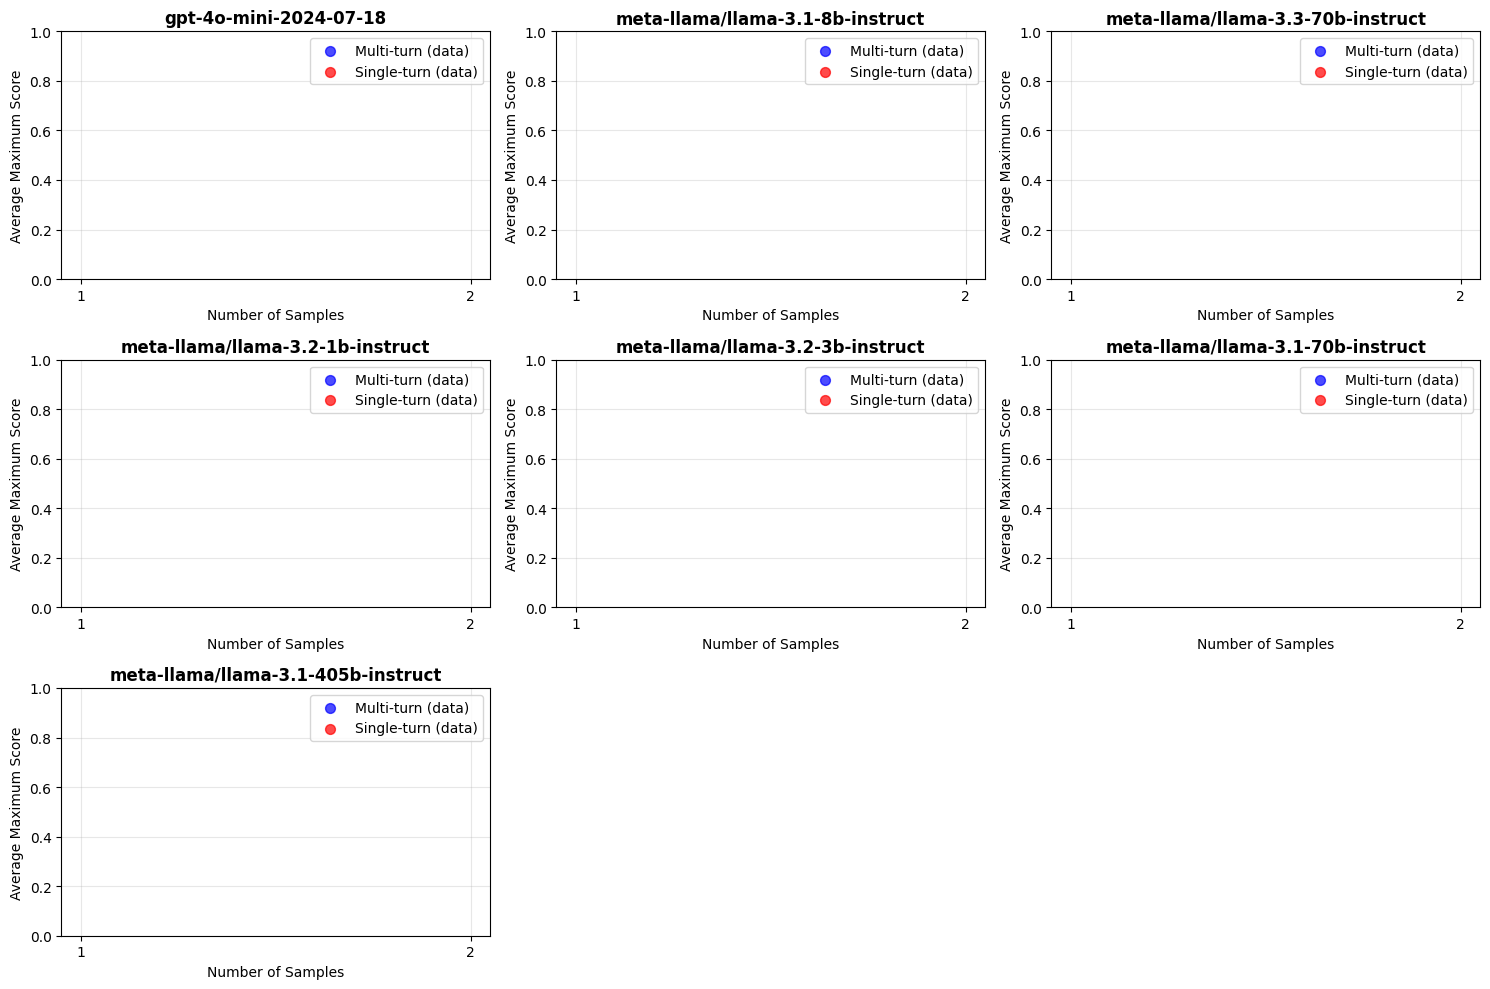

In [25]:
# Plot results by turn type (main analysis) - only run if we have data
if len(metadata) > 0:
    print("Generating ASR vs Samples analysis plots...")
    
    # Generate save path with timestamp to avoid overwrites
    import time
    timestamp = int(time.time())
    save_path = f"../result_figures/asr_samples_direct_request_analysis_by_turn_{timestamp}"
    
    plot_max_scores_by_model(metadata, by_turn_type=True, save_path=save_path)
else:
    print("No metadata available for plotting. Please run the data loading cells first.")